__Student info:__

- Student name: Thomas Brown
- Student pace: Full Time
- Scheduled project review date/time: TBD
- Instructor name: Abhineet Kulkarni
- Blog post URL: TBD

__Use Case:__<br><br>
The purpose of this project is to start building a neural network model that can determine the sentiment of financial news headlines.  The users of this model would be investment firms who want to keep track of the market sentiment of a set of various products, companies, or industries.  <br><br>
With proper web scraping and feeding of new headlines, a firm would be able to keep track of various topics to make better informed investing decisions.  For example, one could feasibly keep track of terms that are rising rapidly in terms of positive sentiment in order to invest in them.<br><br>
The data is collected from Kaggle through this [link](https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news).  It's a collection of 4,837 unique news headlines from various financial news sources. 

## Importing Libraries:

In [1]:
import pandas as pd
import numpy as np

# Scikit-Learn:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import svm
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


# Keras:
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout
from keras.utils import to_categorical
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling1D
from keras.callbacks import EarlyStopping



# NLTK - Stopwords:
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet


# Sampling:
from imblearn.over_sampling import SMOTE, ADASYN

# XGBoost:
import xgboost as xgb

# Plots and Graphs:
from wordcloud import WordCloud
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import plotly.express as px
import scikitplot as skplt 
%matplotlib inline

# Other:
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
# So we can see the entire column:
pd.set_option('display.max_colwidth', -1)

Using TensorFlow backend.
/Users/Thomas/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


# Importing Data:

In [2]:
df = pd.read_csv('all-data.csv', names = ['Sentiment', 'Headline'], 
                 encoding='latin-1')
df = df.sample(frac=1).reset_index(drop=True) # Shuffling the data in case there's an ordering bias
display(df.head())
print("Shape:", df.shape, "\n\n")
print(df.info())

Sentiment  \
0  neutral    
1  neutral    
2  neutral    
3  neutral    
4  neutral    

                                                                                                                                     Headline  
0  In 2007 , almost two thirds of Orion 's net sales came from these drugs .                                                                   
1  The business goals for 2009 will realize with the temporary lay-offs carried out in the summer of 2009 , and with other savings measures .  
2  Also the development of online businesses will continue .                                                                                   
3  The product 's front-edge folding maximizes weather resilience and enables a seamless roof finish .                                         
4  The company is also seeking possibilities to relocate the Luumaki personnel , some 50 people , to other UPM mills .

Shape: (4846, 2) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
Sentiment    4846 non-null object
Headline     4846 non-null object
dtypes: object(2)
memory usage: 75.8+ KB
None


In [3]:
# Let's take a look at the number of instances of each sentiment:
df.Sentiment.value_counts()
# Not too many negatives.  This may prove to be an issue later on, but for now, let's keep moving.

neutral     2879
positive    1363
negative    604 
Name: Sentiment, dtype: int64

# Cleaning Data:

First, the labels need to be changed to numerical values in order to go through the neural network later on. Due to a low number of negative articles compared to the rest, I'll be treating this as a binary problem: 'Positive' vs 'Not Positive'.

- 0 is Negative or Neutral
- 1 is Positive

In [4]:
# BINARY
df['Sentiment'] = df['Sentiment'].map(lambda x: 1 if x == 'positive' else 0)
df.head()

Sentiment  \
0  0           
1  0           
2  0           
3  0           
4  0           

                                                                                                                                     Headline  
0  In 2007 , almost two thirds of Orion 's net sales came from these drugs .                                                                   
1  The business goals for 2009 will realize with the temporary lay-offs carried out in the summer of 2009 , and with other savings measures .  
2  Also the development of online businesses will continue .                                                                                   
3  The product 's front-edge folding maximizes weather resilience and enables a seamless roof finish .                                         
4  The company is also seeking possibilities to relocate the Luumaki personnel , some 50 people , to other UPM mills .

## Stopwords:

Next, we can remove all the 'stopwords' that can clog up the system later on.  The punctuation will get filtered out later.

In [5]:
stop = set(stopwords.words('english'))
stop.add("'s")
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

df['Headline'] = df['Headline'].map(remove_stopwords)

In [6]:
df.head()

Sentiment  \
0  0           
1  0           
2  0           
3  0           
4  0           

                                                                                  Headline  
0  2007 , almost two thirds orion net sales came drugs .                                    
1  business goals 2009 realize temporary lay-offs carried summer 2009 , savings measures .  
2  also development online businesses continue .                                            
3  product front-edge folding maximizes weather resilience enables seamless roof finish .   
4  company also seeking possibilities relocate luumaki personnel , 50 people , upm mills .

## Lemmatization:

In [7]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [8]:
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    text = [wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in text.split()]
    return " ".join(text)

df['Headline'] = df['Headline'].map(lemmatize)

In [9]:
# Still looking good
df.head()

Sentiment  \
0  0           
1  0           
2  0           
3  0           
4  0           

                                                                              Headline  
0  2007 , almost two third orion net sale come drug .                                   
1  business goal 2009 realize temporary lay-offs carry summer 2009 , saving measure .   
2  also development online business continue .                                          
3  product front-edge fold maximizes weather resilience enables seamless roof finish .  
4  company also seek possibility relocate luumaki personnel , 50 people , upm mill .

# EDA:

In [10]:
# Let's start by exploring sentence length vs sentiment:
df_eda = pd.read_csv('all-data.csv', names = ['Sentiment', 'Headline'], 
                     encoding='latin-1')
df_eda = df_eda.sample(frac=1).reset_index(drop=True) # Shuffling the data in case there's an ordering bias
df_eda['Sentiment'] = df_eda['Sentiment'].map(lambda x: 'positive' if x == 'positive' else 'neutral/neg')
# Same dataset as before:

In [11]:
sent_len = []
for row in df_eda.Headline:
    x = (len(row.split()))
    sent_len.append(x)
    
df_eda['Sentence_Length'] = sent_len

In [12]:
df_eda.head()

Sentiment  \
0  neutral/neg   
1  neutral/neg   
2  neutral/neg   
3  positive      
4  neutral/neg   

                                                                                                                                                                                                        Headline  \
0  In the Czech Republic , the profiling unit at Ostrava will be closed and the machinery will be relocated to Ruukki 's bigger plants in Hungary , Poland and Romania by the end of the first quarter of 2009 .   
1  Metso will provide a recovery boiler with a capacity of 6,800 tonnes of dry solids per day and an evaporation plant with six thermal stages and a capacity of 1,600 tonnes per hour .                           
2  In Finland , export industry forms a large clientele for the packaging industry .                                                                                                                               
3  EPS grew to 0.04 eur from 0.02 eur .                                                                                                                                                                            
4  Protalix closed at $ 10.71 on Friday on the American Stock Exchange , giving a market cap of $ 827 million .                                                                                                    

   Sentence_Length  
0  40               
1  34               
2  14               
3  9                
4  22

In [13]:
import seaborn as sns

In [14]:
df_pos = df_eda[df_eda['Sentiment'] == 'positive']
df_neg = df_eda[df_eda['Sentiment'] == 'neutral/neg']

Positive Headlines - Green, and Negative/Neutral Headlines - Blue


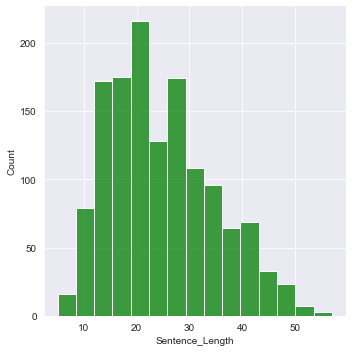

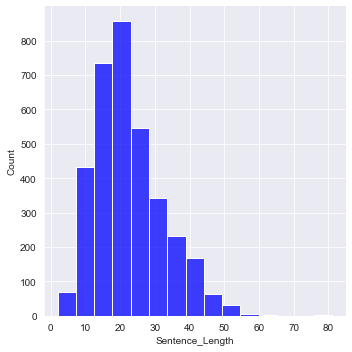

In [15]:
print ('Positive Headlines - Green, and Negative/Neutral Headlines - Blue') 
sns.displot(df_pos, x = 'Sentence_Length', color = 'g', bins = 15)
sns.displot(df_neg, x = 'Sentence_Length', color = 'b', bins = 15);

Positive headlines (Green) appear to more commonly be longer, but it's a bit too close to tell for certain.

Let's explore some word clouds to see the most commonly occurring words for each label.

In [16]:
# Separating out the categories
pos = df.Headline[df.Sentiment[df.Sentiment== 1].index]
neg = df.Headline[df.Sentiment[df.Sentiment== 0].index]

In [17]:
 def wordcloud(dataset):
    plt.figure(figsize = (18,24)) # Text Reviews with positive Ratings
    wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1200 , height = 800).generate(" ".join(dataset))
    plt.imshow(wordcloud,interpolation = 'bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show();

def show_wordclouds():
    print ('Positive Sentiment Wordcloud:')
    wordcloud(pos)
    ###
    print ('Negative Sentiment Wordcloud:')
    wordcloud(neg)
    ###
    

Positive Sentiment Wordcloud:


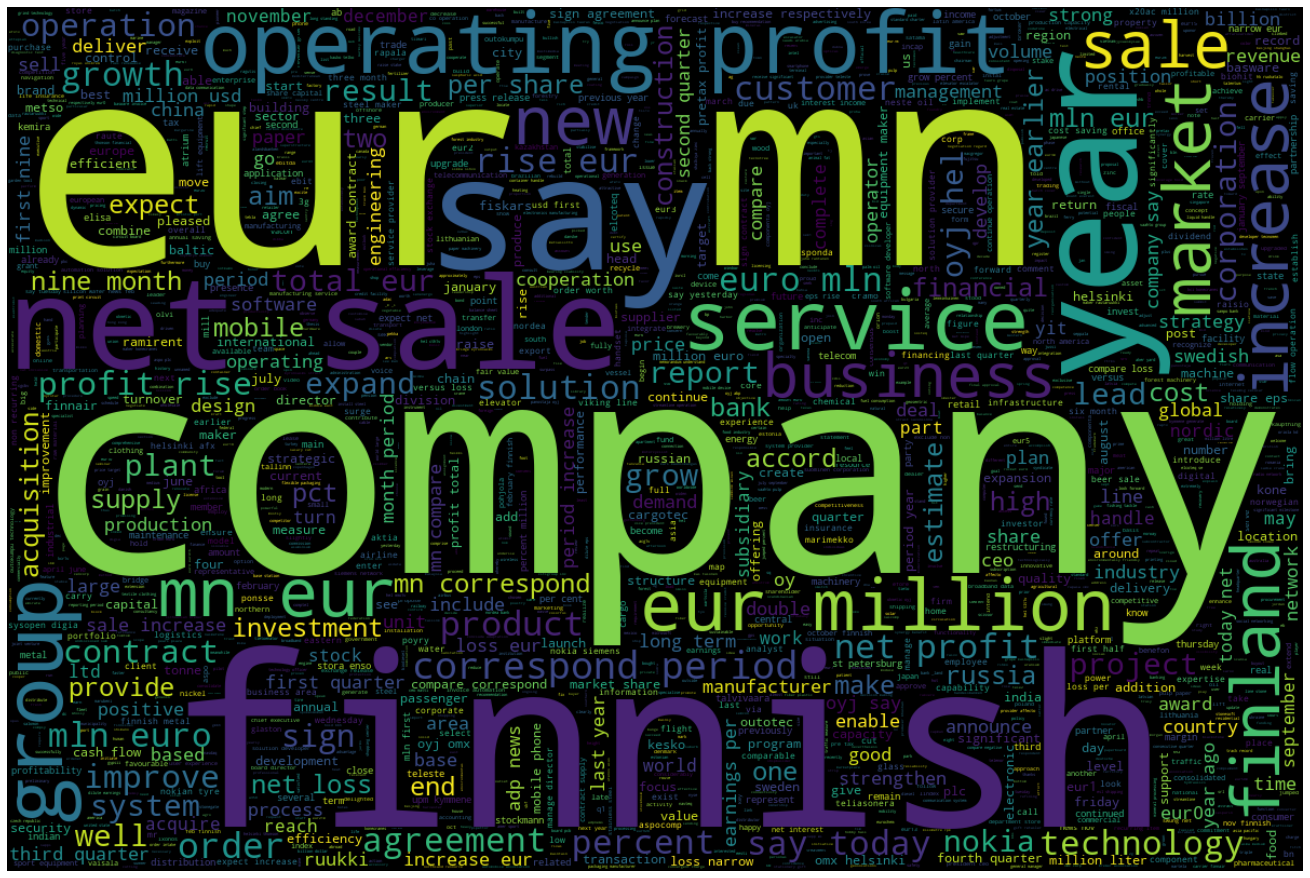

Negative Sentiment Wordcloud:


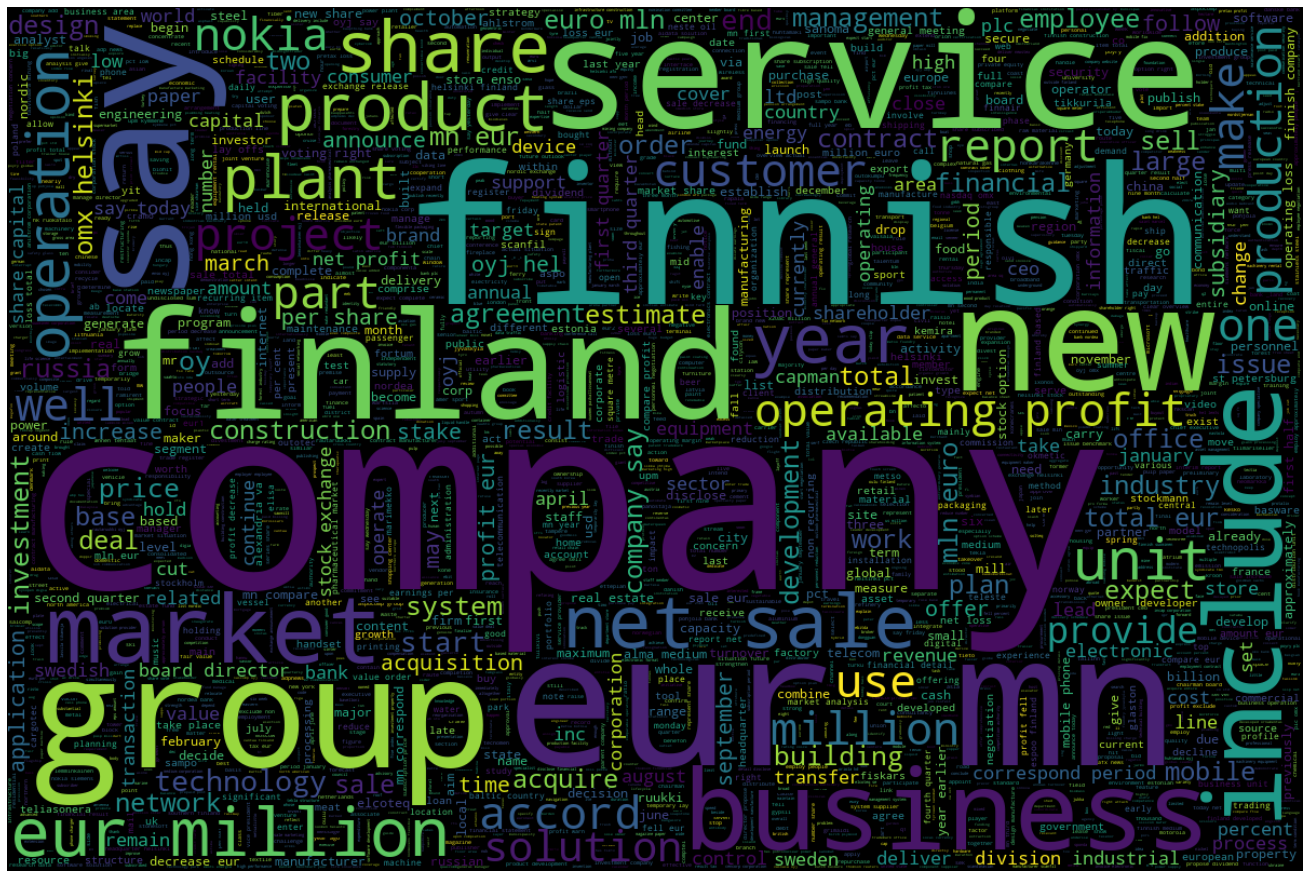

In [18]:
# Showing Word Clounds
show_wordclouds()

Not too much useful information here.  There are some more words we can clean, but I would like to stay on the conservative side for now.

# Additional Cleaning:

As we saw above, there are a few words that are quite common that occur in all 3 labels.  We'll add this to these to the stop word list and run the headlines through the filter again:
- 'finnish'
- 'say'
- 'company'
I'm leaving in 'eur' for now as it doesn't appear heavily in the 'Neutral' category.  This may help later on.  Depending on how the neural network performs later, I may or may not activate the following cells.

In [19]:
# Taking out a few more stop words:
stop.add("finnish")
stop.add("say")
stop.add("company")

df['Headline'] = df['Headline'].map(remove_stopwords)

In [20]:
# Starting to feel a little like caveman speak, but hopefully this will be easier for the model to read!
df.head()

Sentiment  \
0  0           
1  0           
2  0           
3  0           
4  0           

                                                                              Headline  
0  2007 , almost two third orion net sale come drug .                                   
1  business goal 2009 realize temporary lay-offs carry summer 2009 , saving measure .   
2  also development online business continue .                                          
3  product front-edge fold maximizes weather resilience enables seamless roof finish .  
4  also seek possibility relocate luumaki personnel , 50 people , upm mill .

In [21]:
pos = df.Headline[df.Sentiment[df.Sentiment== 1].index]
neg = df.Headline[df.Sentiment[df.Sentiment== 0].index]


Positive Sentiment Wordcloud:


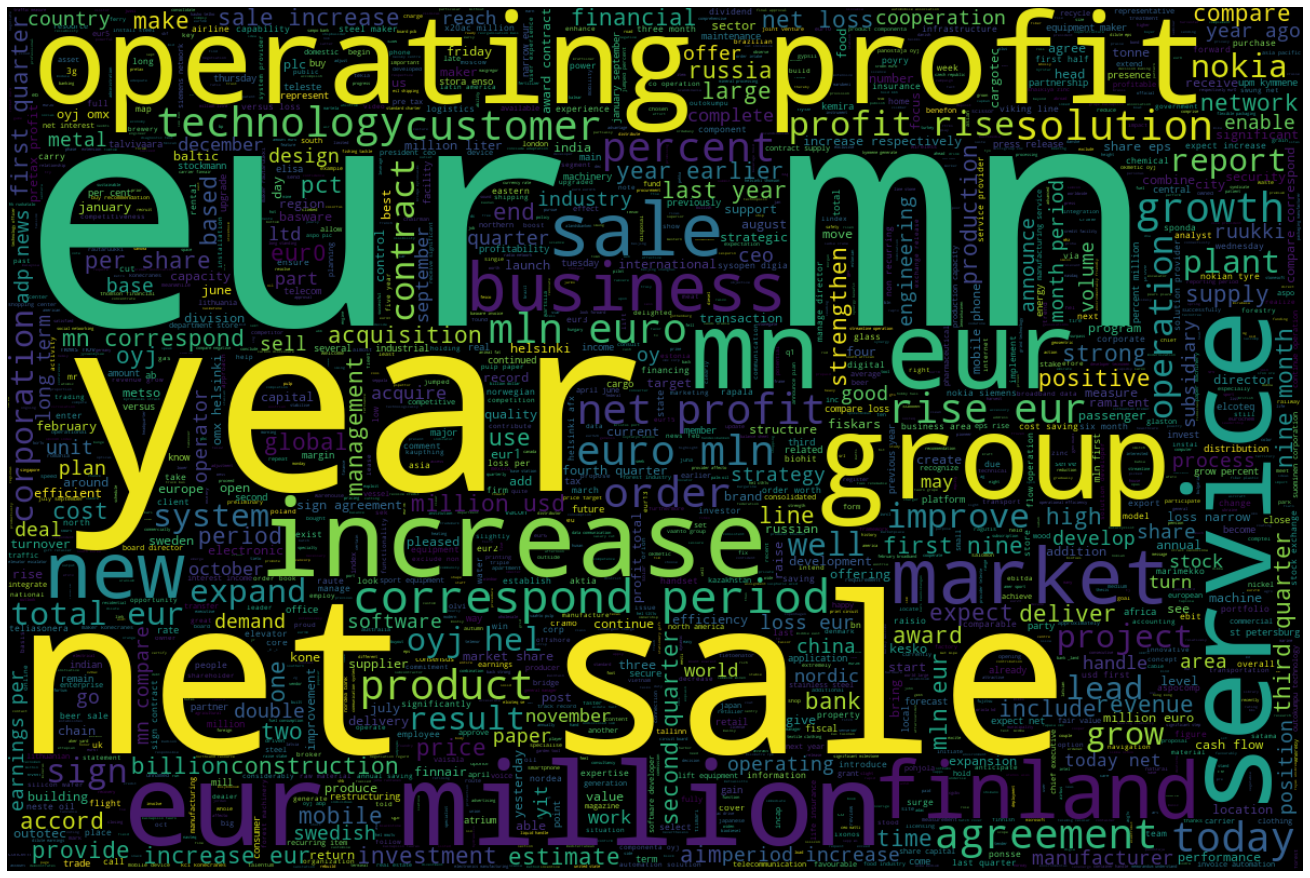

Negative Sentiment Wordcloud:


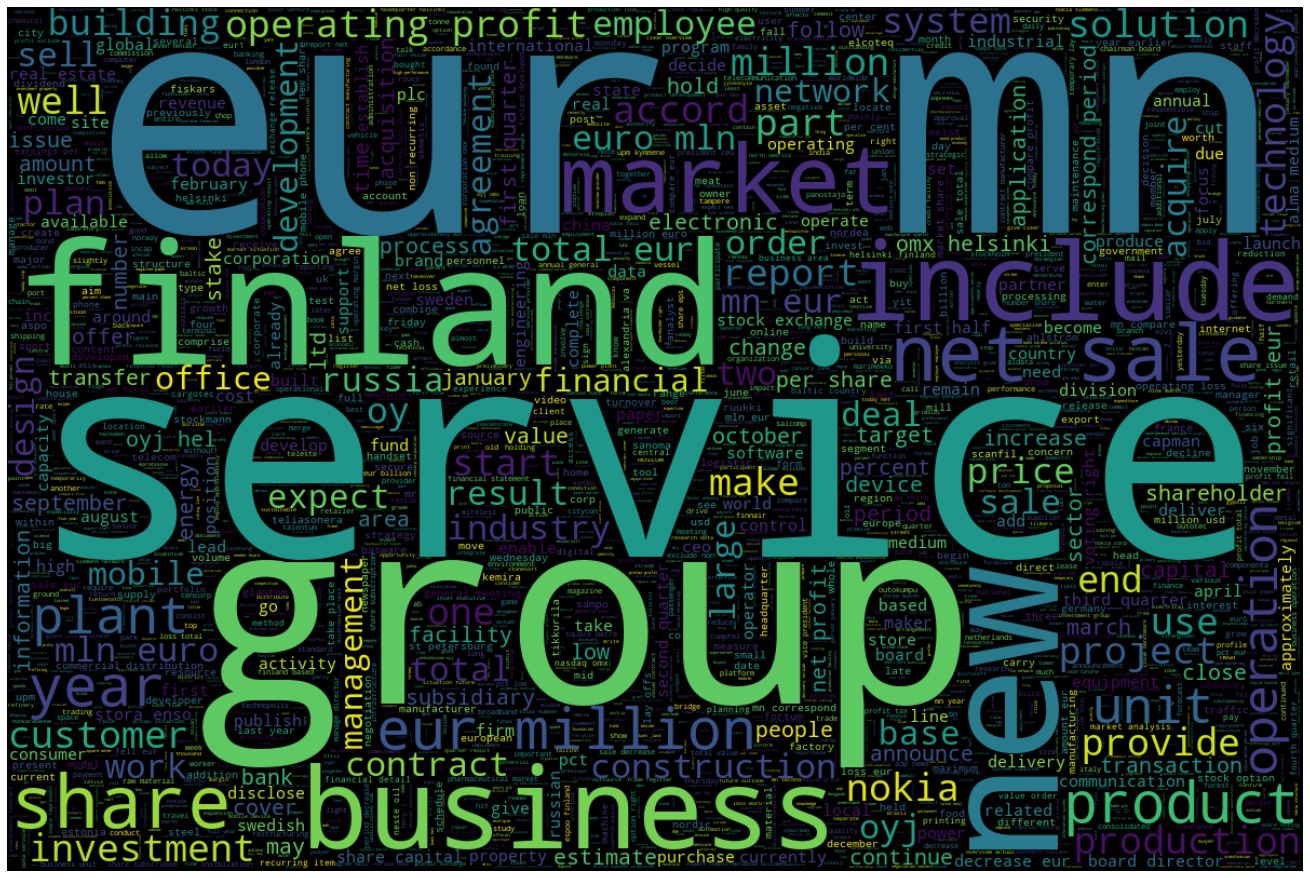

In [22]:
# Showing Word Clounds with additional words removed
show_wordclouds()

# Counter:

In [23]:
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [24]:
text = df.Headline
counter = counter_word(text)

In [25]:
len(counter)

10094

In [26]:
# showing the first 25 rows of the counter
n = 25
out = dict(list(counter.items())[0: n])  
out

{'2007': 243,
 ',': 4662,
 'almost': 15,
 'two': 85,
 'third': 77,
 'orion': 11,
 'net': 413,
 'sale': 501,
 'come': 45,
 'drug': 5,
 '.': 4780,
 'business': 285,
 'goal': 12,
 '2009': 297,
 'realize': 6,
 'temporary': 20,
 'lay-offs': 17,
 'carry': 31,
 'summer': 20,
 'saving': 29,
 'measure': 41,
 'also': 224,
 'development': 91,
 'online': 26,
 'continue': 62}

In [27]:
num_words = len(counter)

# Train/Test Split:

In [28]:
# Generating the lists of headlines and labels
headlines = []
labels = []

for row in range(len(df)):
    headlines.append(df['Headline'][row])
    labels.append(df['Sentiment'][row])

In [29]:
# Setting the training ratio
training_size = int(df.shape[0] * .8) # Out of 4846

In [30]:
# Train Test Split:
training_headlines = headlines[0:training_size]
testing_headlines = headlines[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [31]:
# Looks good
display(training_headlines[:3])
display(training_labels[:3])

['2007 , almost two third orion net sale come drug .',
 'business goal 2009 realize temporary lay-offs carry summer 2009 , saving measure .',
 'also development online business continue .']

[0, 0, 0]

# Tokenization:

In [32]:
vocab_size = len(counter) # approx 1/5 of the words 
embedding_dim = 32
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [33]:

# Initializing the fitting the tokenizer:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(training_headlines)
# Initializing the Word Index:
word_index = tokenizer.word_index
# Padding and Sequencing the Training Set:
training_sequences = tokenizer.texts_to_sequences(training_headlines)
training_padded = pad_sequences(training_sequences, maxlen = max_length,
                               padding = padding_type, 
                               truncating = trunc_type)
# Padding and Sequencing the Testing Set:
testing_sequences = tokenizer.texts_to_sequences(testing_headlines)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, 
                               padding = padding_type, 
                               truncating = trunc_type)


In [34]:
# Switch to Numpy Array
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [35]:
# Example of what's happening under the hood:
print ('Padded and Tokenized Headline:\n', training_padded[3])
print ('\nThe actual headline:\n', df.Headline[3])
print ('\nLabel:\n', training_labels[3])

Padded and Tokenized Headline:
 [  45 1030 1548 1549 3725 1769 3726  563 3727 1550 1374    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]

The actual headline:
 product front-edge fold maximizes weather resilience enables seamless roof finish .

Label:
 0


## Taking a Look at Inputs:

In [36]:
# So far looks good:
n = 0

display(training_headlines[n])
print('-----------------')
display(training_padded[n])
print('-----------------')
display(training_labels[n])
print('-----------------')

display(testing_headlines[n])
print('-----------------')
display(testing_padded[n])
print('-----------------')
display(testing_labels[n])
print('-----------------')


'2007 , almost two third orion net sale come drug .'

-----------------


array([  29,  823,  113,  128, 1028,    9,    3,  254, 1546,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

-----------------


0

-----------------


'apart nordea , also ergo compete position among top three pension fund provider estonia .'

-----------------


array([2863,  262,   36,    1, 2986,  273,  934,  890,  212,  938,  245,
        226,  443,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

-----------------


0

-----------------


In [37]:
# Making sure all our data works. . . 
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '-') for i in text])

print(decode_sentence(training_padded[1]))
print(training_headlines[1])
print(labels[1])

business goal 2009 realize temporary lay offs carry summer 2009 saving measure - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
business goal 2009 realize temporary lay-offs carry summer 2009 , saving measure .
0


# Modeling:

## Baseline with Vader:

Vader is a commonly used sentiment analysis toolbox.  Let's see if we can use it as a baseline against the artificial neural network I'll build later on in the notebook.

In [38]:
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [39]:
# Vader Accuracy:
# Making a new dataframe to mess around in:
df2 = pd.read_csv('all-data.csv', names = ['Sentiment', 'Headline'], 
                 encoding='latin-1')
df2 = df2.sample(frac=1).reset_index(drop=True) # Shuffling the data in case there's an ordering bias
df2['Sentiment'] = df2['Sentiment'].map(lambda x: 1 if x == 'positive' else 0)
df2['vader_sent'] = 0 # Placeholder as 0
df2 = df2[['Sentiment', 'vader_sent', 'Headline']]
df2.head()

Sentiment  vader_sent  \
0  0          0            
1  1          0            
2  0          0            
3  0          0            
4  0          0            

                                                                                                                              Headline  
0  The talks involved the Food and Ingredients Divisions , as well as group service functions , the company said .                      
1  In the second quarter of 2010 , the group 's net profit rose to EUR3 .1 m from EUR2 .5 m in April-June 2009 .                        
2  Swedish engineering consultant firm Etteplan is to establish a unit in town Borl+Ænge , by the turn of the month March-April 2008 .  
3  Vacon 's office will support its customers in Brazil and South America .                                                             
4  Cohen & Steers , Inc. : 5 534 626 shares representing 4.985 % of the share capital and voting rights .

In [40]:
# Sanity check:
x = sid.polarity_scores('This is a happy sentence!')
print (x)
print (x['compound'])

{'neg': 0.0, 'neu': 0.274, 'pos': 0.726, 'compound': 0.6476}
0.6476


In [41]:
vader_sent_list = []
for row in df2.Headline:
    x = sid.polarity_scores(row)['compound']
    vader_sent_list.append(x)
    
df2.vader_sent = vader_sent_list
df2.head()
# Looks good, but we'll need to change vader_sent to the same format as Sentiment
# The 'Compound' score we're using uses a scale of -1 to 1, while Sentiment is 0 to 1

Sentiment  vader_sent  \
0  0          0.2732       
1  1          0.4404       
2  0          0.0000       
3  0          0.4019       
4  0          0.5267       

                                                                                                                              Headline  
0  The talks involved the Food and Ingredients Divisions , as well as group service functions , the company said .                      
1  In the second quarter of 2010 , the group 's net profit rose to EUR3 .1 m from EUR2 .5 m in April-June 2009 .                        
2  Swedish engineering consultant firm Etteplan is to establish a unit in town Borl+Ænge , by the turn of the month March-April 2008 .  
3  Vacon 's office will support its customers in Brazil and South America .                                                             
4  Cohen & Steers , Inc. : 5 534 626 shares representing 4.985 % of the share capital and voting rights .

In [42]:
# Greater than 50% on the vader compound gets it classified as a 1 i.e. 'positive'
df2['vader_sent'] = df2['vader_sent'].map(lambda x: 1 if x > 0 else 0)
df2.head()

Sentiment  vader_sent  \
0  0          1            
1  1          1            
2  0          0            
3  0          1            
4  0          1            

                                                                                                                              Headline  
0  The talks involved the Food and Ingredients Divisions , as well as group service functions , the company said .                      
1  In the second quarter of 2010 , the group 's net profit rose to EUR3 .1 m from EUR2 .5 m in April-June 2009 .                        
2  Swedish engineering consultant firm Etteplan is to establish a unit in town Borl+Ænge , by the turn of the month March-April 2008 .  
3  Vacon 's office will support its customers in Brazil and South America .                                                             
4  Cohen & Steers , Inc. : 5 534 626 shares representing 4.985 % of the share capital and voting rights .

In [43]:
# Score counter for accuracy:
# 1 for match, 0 for no match
df2['vader_sent_match'] = 1 - abs(df2['vader_sent'] - df2['Sentiment'])
df2 = df2[['Sentiment', 'vader_sent', 'vader_sent_match', 'Headline']]
df2.head(10)

Sentiment  vader_sent  vader_sent_match  \
0  0          1           0                  
1  1          1           1                  
2  0          0           1                  
3  0          1           0                  
4  0          1           0                  
5  0          1           0                  
6  1          1           1                  
7  0          0           1                  
8  0          0           1                  
9  1          1           1                  

                                                                                                                                                 Headline  
0  The talks involved the Food and Ingredients Divisions , as well as group service functions , the company said .                                         
1  In the second quarter of 2010 , the group 's net profit rose to EUR3 .1 m from EUR2 .5 m in April-June 2009 .                                           
2  Swedish engineering consultant firm Etteplan is to establish a unit in town Borl+Ænge , by the turn of the month March-April 2008 .                     
3  Vacon 's office will support its customers in Brazil and South America .                                                                                
4  Cohen & Steers , Inc. : 5 534 626 shares representing 4.985 % of the share capital and voting rights .                                                  
5  The newspapers of Alma Media and Arena Partners will enter a cooperation agreement on using Alma 's marketplace services in their respective regions .  
6  Bilfinger investors cheered the agreement , pushing shares up 7 % , or & euro ; 3.30 , to & euro ; 50.29 , in afternoon trade .                         
7  Nordea will coordinate the syndicated loan .                                                                                                            
8  He does not believe , however , that HKScan or Atria will start to use imported meat as Finnish consumers prefer domestic products .                    
9  The move is aimed at boosting sales , cost-efficiency and market share in Finland .

In [44]:
x = sum(df2['vader_sent_match'])
y = len(df2)
print ('Correct Vader Classifications:', x, 'out of', y)
print ('Percentage Correct:', '{:.2%}'.format(x/y))

Correct Vader Classifications: 3004 out of 4846
Percentage Correct: 61.99%


With the threshold of greater than 50% classified as 'Positive', we got 62% accuracy with Vader.  Let's see if we can do a better job with an artificial neural network.

# Neural Network:

In [45]:
# First let's define the functions for model evaluation
def model_eval(history):
    pd.DataFrame(history.history).plot(figsize = (12,8)) # Was 8, 5 before
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

def model_metrics(model):
    train_acc = model.evaluate(training_padded, training_labels, verbose=0)
    test_acc = model.evaluate(testing_padded, testing_labels, verbose=0)
    print('Train Loss:', "{:.3%}".format(train_acc[0]))
    print('Train Accuracy:', "{:.3%}".format(train_acc[1]))
    print('Test Loss:', "{:.3%}".format(test_acc[0]))
    print('Test Accuracy:', "{:.3%}".format(test_acc[1]))
    
def easy_headlines():
    sentence = ["stock rise rapid for tesla", 
                "apple factory shut down, lay off hundred employee",
                "average day of return for microsoft"]
    sequences = tokenizer.texts_to_sequences(sentence)
    padded = pad_sequences(sequences, maxlen=max_length, 
                           padding=padding_type, 
                           truncating=trunc_type)
    for headline in sentence:    
        print (headline)
    print(model.predict(padded))
    
def harder_headlines():
    sentence = ["snowflake more  double  debut  wall street embrace tech ipos", 
                "europe economic revival imperil raising the specter grind downturn",
                "fed debate next step after shifting approach to rate setting"]
    sequences = tokenizer.texts_to_sequences(sentence)
    padded = pad_sequences(sequences, maxlen=max_length, 
                           padding=padding_type, 
                           truncating=trunc_type)
    for headline in sentence:    
        print (headline)
    print(model.predict(padded))

    
def test_headlines():
    print('Easier Headlines:')
    easy_headlines()
    print ('\n')
    print ('Realistic Headlines:')
    harder_headlines()

Now it's time to build a baseline neural network:

## Model 1 (1 Hidden Layer):

In [46]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GlobalAveragePooling1D())
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.2)) # Optional Regularization
#model.add(Dense(150, activation='relu')) # Optional second hidden layer
#model.add(Dropout(0.2)) # Optional Regularization
model.add(Dense(1, activation='sigmoid'))

#model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy']) # Orig code

#Messing with learning rate
opt = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy',optimizer= opt, 
              metrics=['accuracy']) # Orig code

In [47]:
num_epochs = 50
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(training_padded, training_labels, 
                    epochs=num_epochs,
                    batch_size = 10,
                    validation_data=(testing_padded, testing_labels), 
                    verbose= 1, callbacks=[es])

Train on 3876 samples, validate on 970 samples
Epoch 1/50
3876/3876 [==============================] - 2s 570us/step - loss: 0.6418 - acc: 0.7178 - val_loss: 0.5998 - val_acc: 0.7216
Epoch 2/50
3876/3876 [==============================] - 2s 506us/step - loss: 0.5889 - acc: 0.7180 - val_loss: 0.5872 - val_acc: 0.7216
Epoch 3/50
3876/3876 [==============================] - 2s 507us/step - loss: 0.5835 - acc: 0.7180 - val_loss: 0.5850 - val_acc: 0.7216
Epoch 4/50
3876/3876 [==============================] - 2s 514us/step - loss: 0.5798 - acc: 0.7180 - val_loss: 0.5829 - val_acc: 0.7216
Epoch 5/50
3876/3876 [==============================] - 2s 518us/step - loss: 0.5745 - acc: 0.7180 - val_loss: 0.5798 - val_acc: 0.7216
Epoch 6/50
3876/3876 [==============================] - 2s 509us/step - loss: 0.5679 - acc: 0.7180 - val_loss: 0.5761 - val_acc: 0.7227
Epoch 7/50
3876/3876 [==============================] - 2s 508us/step - loss: 0.5602 - acc: 0.7178 - val_loss: 0.5713 - val_acc: 0.7227
E

### Model Evaluation:

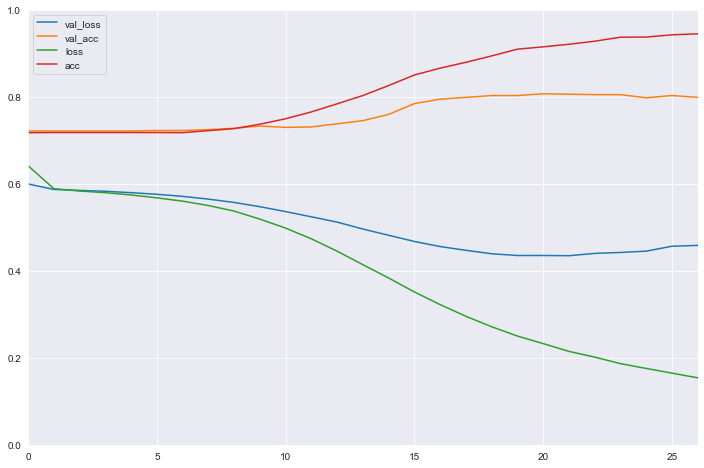

In [48]:
model_eval(history)

In [49]:
model_metrics(model)

Train Loss: 14.403%
Train Accuracy: 95.175%
Test Loss: 45.854%
Test Accuracy: 79.897%


In [50]:
test_headlines()

Easier Headlines:
stock rise rapid for tesla
apple factory shut down, lay off hundred employee
average day of return for microsoft
[[0.71484965]
 [0.01404744]
 [0.50260574]]


Realistic Headlines:
snowflake more  double  debut  wall street embrace tech ipos
europe economic revival imperil raising the specter grind downturn
fed debate next step after shifting approach to rate setting
[[0.23693302]
 [0.19169477]
 [0.38577157]]


## Model 2 (2 Hidden Layers):

In [51]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GlobalAveragePooling1D())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2)) # Optional Regularization
model.add(Dense(50, activation='relu')) # Optional second hidden layer
model.add(Dropout(0.2)) # Optional Regularization
model.add(Dense(1, activation='sigmoid'))

#model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy']) # Orig code

#Messing with learning rate
opt = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy',optimizer= opt, 
              metrics=['accuracy']) # Orig code


In [52]:
num_epochs = 50
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(training_padded, training_labels, 
                    epochs=num_epochs,
                    batch_size = 10,
                    validation_data=(testing_padded, testing_labels), 
                    verbose= 1, callbacks=[es])

Train on 3876 samples, validate on 970 samples
Epoch 1/50
3876/3876 [==============================] - 2s 554us/step - loss: 0.6511 - acc: 0.7059 - val_loss: 0.6048 - val_acc: 0.7216
Epoch 2/50
3876/3876 [==============================] - 2s 466us/step - loss: 0.5930 - acc: 0.7180 - val_loss: 0.5877 - val_acc: 0.7216
Epoch 3/50
3876/3876 [==============================] - 2s 464us/step - loss: 0.5869 - acc: 0.7180 - val_loss: 0.5857 - val_acc: 0.7216
Epoch 4/50
3876/3876 [==============================] - 2s 463us/step - loss: 0.5830 - acc: 0.7180 - val_loss: 0.5834 - val_acc: 0.7216
Epoch 5/50
3876/3876 [==============================] - 2s 465us/step - loss: 0.5793 - acc: 0.7180 - val_loss: 0.5805 - val_acc: 0.7216
Epoch 6/50
3876/3876 [==============================] - 2s 469us/step - loss: 0.5715 - acc: 0.7180 - val_loss: 0.5765 - val_acc: 0.7216
Epoch 7/50
3876/3876 [==============================] - 2s 465us/step - loss: 0.5640 - acc: 0.7180 - val_loss: 0.5709 - val_acc: 0.7216
E

### Model Evaluation:

In [53]:
model_metrics(model)

Train Loss: 14.008%
Train Accuracy: 94.917%
Test Loss: 47.858%
Test Accuracy: 80.000%


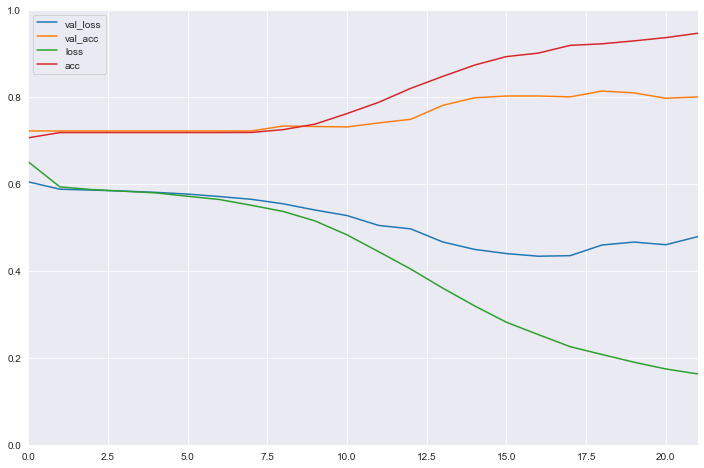

In [54]:
model_eval(history)

In [55]:
test_headlines()

Easier Headlines:
stock rise rapid for tesla
apple factory shut down, lay off hundred employee
average day of return for microsoft
[[0.66316   ]
 [0.00784913]
 [0.4392381 ]]


Realistic Headlines:
snowflake more  double  debut  wall street embrace tech ipos
europe economic revival imperil raising the specter grind downturn
fed debate next step after shifting approach to rate setting
[[0.15966494]
 [0.0960837 ]
 [0.2943007 ]]


## Model 3 (LSTM):

LSTM (Long Short Term Memory) models are quite popular as well for NLP.  Let's give it a try.

In [56]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(LSTM(64, dropout = 0.1))
model.add(Dense(35, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy']) # Orig code

In [57]:
num_epochs = 50
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(training_padded, training_labels, 
                    epochs=num_epochs,
                    batch_size = 24,
                    validation_data=(testing_padded, testing_labels), 
                    verbose= 1, callbacks = [es])

Train on 3876 samples, validate on 970 samples
Epoch 1/50
3876/3876 [==============================] - 10s 3ms/step - loss: 0.6040 - acc: 0.7175 - val_loss: 0.5943 - val_acc: 0.7216
Epoch 2/50
3876/3876 [==============================] - 9s 2ms/step - loss: 0.5351 - acc: 0.7291 - val_loss: 0.5390 - val_acc: 0.6701
Epoch 3/50
3876/3876 [==============================] - 9s 2ms/step - loss: 0.4441 - acc: 0.7735 - val_loss: 0.5593 - val_acc: 0.6608
Epoch 4/50
3876/3876 [==============================] - 10s 3ms/step - loss: 0.4361 - acc: 0.7812 - val_loss: 0.5603 - val_acc: 0.6588
Epoch 5/50
3876/3876 [==============================] - 10s 3ms/step - loss: 0.4276 - acc: 0.7910 - val_loss: 0.5728 - val_acc: 0.6608
Epoch 6/50
3876/3876 [==============================] - 10s 2ms/step - loss: 0.4116 - acc: 0.8011 - val_loss: 0.5717 - val_acc: 0.6619
Epoch 7/50
3876/3876 [==============================] - 10s 3ms/step - loss: 0.4093 - acc: 0.8055 - val_loss: 0.5475 - val_acc: 0.7330
Epoch 0000

### Model Evaluation:

In [58]:
model_metrics(model)

Train Loss: 41.279%
Train Accuracy: 83.385%
Test Loss: 54.754%
Test Accuracy: 73.299%


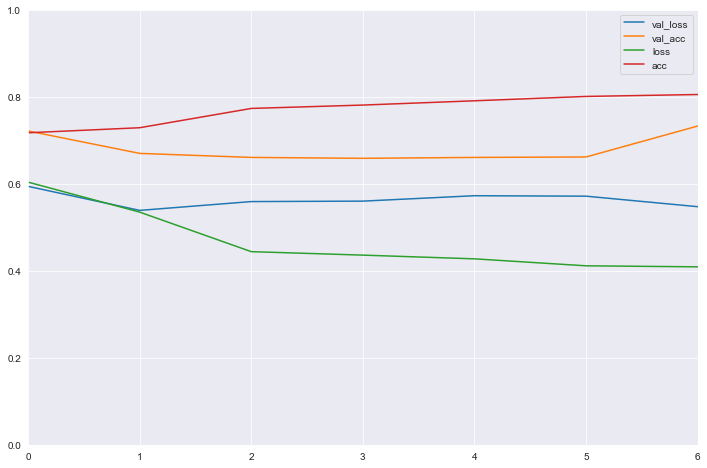

In [59]:
model_eval(history)

In [60]:
test_headlines()

Easier Headlines:
stock rise rapid for tesla
apple factory shut down, lay off hundred employee
average day of return for microsoft
[[0.6384318 ]
 [0.11031161]
 [0.6384212 ]]


Realistic Headlines:
snowflake more  double  debut  wall street embrace tech ipos
europe economic revival imperil raising the specter grind downturn
fed debate next step after shifting approach to rate setting
[[0.6384298 ]
 [0.11031498]
 [0.6384174 ]]


## Transfer Learning with GloVe:

[Source](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/)

Now, I'll be trying out a pre-trained model called GloVe to prime the embedding layer of this project.  Let's see if we can get better results with this network.

In [61]:
from numpy import array
from numpy import asarray
from numpy import zeros

In [62]:
f = open('/Users/Thomas/Desktop/glove.6B/glove.6B.50d.txt')  
# Enormous download for this file.  
# If you're interested in replicating this code, you can download it yourself 
# And replace the path in this cell

In [63]:
embeddings_index = dict()

In [64]:
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [65]:
print('Loaded %s word vectors.' % len(embeddings_index))
# Should be enough. . . 

Loaded 400000 word vectors.


In [66]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 50)) # CHANGING TO 50 DIMENSIONS FROM 100
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [67]:
model = Sequential()
e = Embedding(vocab_size, 50, weights = [embedding_matrix], 
              input_length = max_length, 
              trainable=False)

model.add(e)
model.add(Flatten())
model.add(Dense(200, activation='relu')) # TB Test
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 50)            504700    
_________________________________________________________________
flatten_1 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 200)               500200    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 201       
Total params: 1,005,101
Trainable params: 500,401
Non-trainable params: 504,700
_________________________________________________________________
None


In [68]:
num_epochs = 100
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model.fit(training_padded, training_labels, 
                    epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels), 
                    verbose= 1, callbacks = [es])

Train on 3876 samples, validate on 970 samples
Epoch 1/100
3876/3876 [==============================] - 1s 357us/step - loss: 0.5825 - acc: 0.7090 - val_loss: 0.5468 - val_acc: 0.7268
Epoch 2/100
3876/3876 [==============================] - 1s 250us/step - loss: 0.4168 - acc: 0.8104 - val_loss: 0.5519 - val_acc: 0.7330
Epoch 3/100
3876/3876 [==============================] - 1s 251us/step - loss: 0.3023 - acc: 0.8793 - val_loss: 0.5912 - val_acc: 0.7206
Epoch 4/100
3876/3876 [==============================] - 1s 250us/step - loss: 0.2069 - acc: 0.9309 - val_loss: 0.6040 - val_acc: 0.7351
Epoch 5/100
3876/3876 [==============================] - 1s 250us/step - loss: 0.1323 - acc: 0.9662 - val_loss: 0.6648 - val_acc: 0.7423
Epoch 6/100
3876/3876 [==============================] - 1s 248us/step - loss: 0.0910 - acc: 0.9801 - val_loss: 0.7213 - val_acc: 0.7330
Epoch 7/100
3876/3876 [==============================] - 1s 250us/step - loss: 0.0672 - acc: 0.9884 - val_loss: 0.7561 - val_acc: 0

### Model Evaluation:

In [69]:
model_metrics(model)

Train Loss: 5.327%
Train Accuracy: 99.174%
Test Loss: 97.111%
Test Accuracy: 73.196%


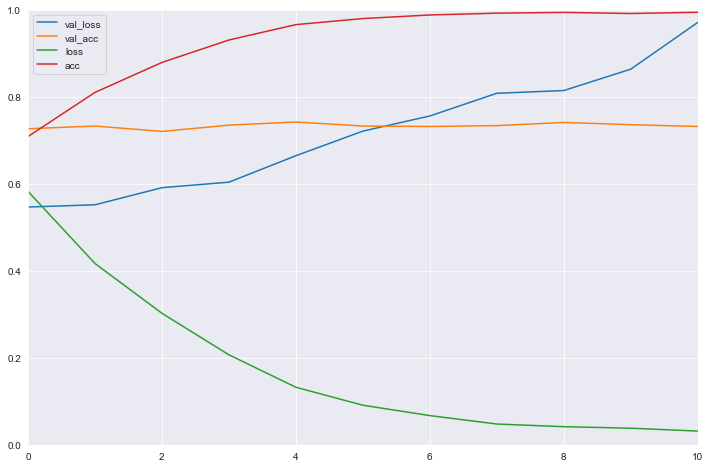

In [70]:
model_eval(history)

In [71]:
test_headlines()

Easier Headlines:
stock rise rapid for tesla
apple factory shut down, lay off hundred employee
average day of return for microsoft
[[9.5279098e-01]
 [8.8219432e-04]
 [2.2308208e-02]]


Realistic Headlines:
snowflake more  double  debut  wall street embrace tech ipos
europe economic revival imperil raising the specter grind downturn
fed debate next step after shifting approach to rate setting
[[0.06465276]
 [0.19517982]
 [0.853292  ]]


Surprisingly, I did not get great performance with this model.  The original embedded layer model worked best.

## Embedding Dimensions:

With the following code, I can download the embedding vectors weights and metadata in order to upload to TensorFlow Projector.  The website is found [here](https://projector.tensorflow.org/), and if you un-comment the following code, run it, download the files, upload them to the projector, and click 'spherize data' you can see the embeddings from the neural network.

An example of this can be found in the gif in the readme file.

In [72]:
'''
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()
'''

'\ne = model.layers[0]\nweights = e.get_weights()[0]\nprint(weights.shape) # shape: (vocab_size, embedding_dim)\n\nimport io\n\nout_v = io.open(\'vecs.tsv\', \'w\', encoding=\'utf-8\')\nout_m = io.open(\'meta.tsv\', \'w\', encoding=\'utf-8\')\nfor word_num in range(1, vocab_size):\n  word = reverse_word_index[word_num]\n  embeddings = weights[word_num]\n  out_m.write(word + "\n")\n  out_v.write(\'\t\'.join([str(x) for x in embeddings]) + "\n")\nout_v.close()\nout_m.close()\n'

# Further Work:

In the future, I'd like to complete the following analysis:
- A web application that collects and analyzes headlines from various financial news sources.
- Other neural network architecture types.
- New types of sentiment analysis, such as breaking news vs an opinion piece on an older issue.
- Rate different newspapers by sentiment value.

# Conclusion:

If I were to put this into production, I would use the first embedded layer model and train it with quite a bit more data.  It would be a challenge to collect, but the model would be able to gain quite a bit more accuracy.  In the end, though, I believe it would ultimately be worth it.

This was a fun challenge.  Sentiment analysis is a fairly tried and true field of study, but it was a bit more of a challenge to try it with financial news headlines.  The words that impart sentiment tend to be much different than those in (for example) Amazon reviews or other common test cases.  

While 80% accuracy has some definite room for improvement, it's not a bad start considering the amount of labeled data that was available for this project.  At some point, I'd love to come back to this with a larger dataset and more experience under my belt working with neural networks and take another crack at this project.

Thanks for reading, and let me know if you have any questions.

-Thomas